In [13]:
# Import necessary libraries
import os
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm

import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, models, transforms

from torch.utils.data import DataLoader
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

In [14]:
# Check device - GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda


In [15]:
# Data transforms (augmentation and normalization)

data_transforms = {
    'train': transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.RandomHorizontalFlip(),
        transforms.RandomRotation(10),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406],  # Imagenet mean
                             [0.229, 0.224, 0.225])  # Imagenet std
    ]),
    'val': transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406],
                             [0.229, 0.224, 0.225])
    ]),
}


In [16]:
# Set dataset paths (Assuming you downloaded and extracted Kaggle dataset)

data_dir = './data/chest_xray'  
# This folder should contain 'train', 'val', and 'test' subfolders with 'PNEUMONIA' and 'NORMAL' inside

In [17]:
# Load datasets
image_datasets = {
    x: datasets.ImageFolder(os.path.join(data_dir, x),
                           transform=data_transforms[x])
    for x in ['train', 'val']
}

# Create dataloaders for batch processing
dataloaders = {
    x: DataLoader(image_datasets[x], batch_size=32, shuffle=True, num_workers=4)
    for x in ['train', 'val']
}

dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val']}
class_names = image_datasets['train'].classes

print(f"Classes: {class_names}")
print(f"Train dataset size: {dataset_sizes['train']}")
print(f"Validation dataset size: {dataset_sizes['val']}")

Classes: ['NORMAL', 'PNEUMONIA']
Train dataset size: 5216
Validation dataset size: 16


In [18]:
import torchvision


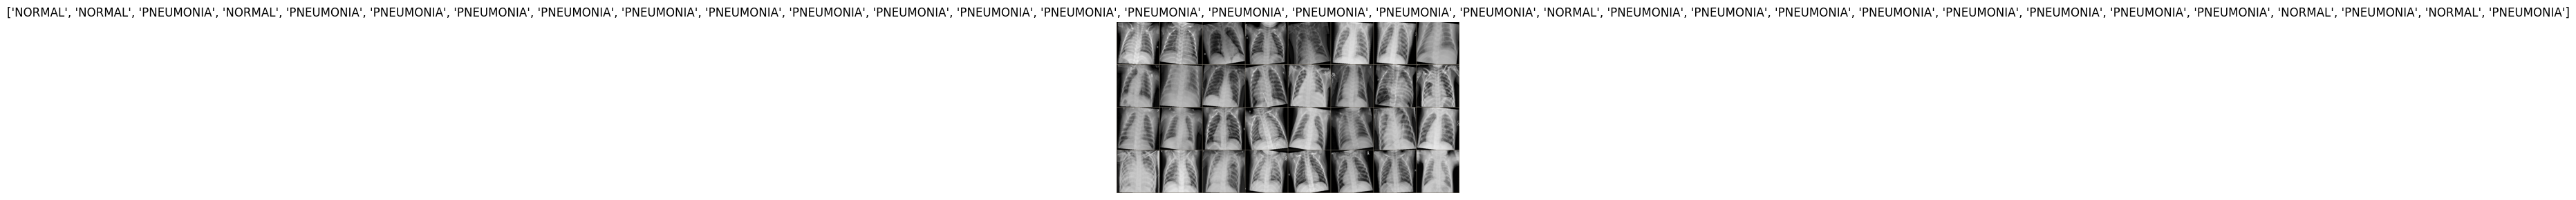

In [19]:
# Visualize some training images

def imshow(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std  = np.array([0.229, 0.224, 0.225])
    inp  = std * inp + mean
    inp  = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title:
        plt.title(title)
    plt.axis('off')
    plt.show()

# Get a batch of training data
inputs, classes = next(iter(dataloaders['train']))

# Make grid
out = torchvision.utils.make_grid(inputs)

imshow(out, title=[class_names[x] for x in classes])

In [20]:
# Load pretrained ResNet50 and modify last layer

model = models.resnet50(pretrained=True)

# Freeze all layers except the final fully connected layer
for param in model.parameters():
    param.requires_grad = False

# Replace the last fully connected layer for 2 classes (pneumonia/normal)
num_features = model.fc.in_features
model.fc = nn.Linear(num_features, 2)

model = model.to(device)


c:\Users\ACHUTH\AppData\Local\Programs\Python\Python312\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\ACHUTH\AppData\Local\Programs\Python\Python312\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [21]:
import torch

# Class counts from your training set
class_counts = [1341, 3875]  # [NORMAL, PNEUMONIA]

# Compute weights: inverse of frequency
weights = [1.0 / count for count in class_counts]
class_weights = torch.FloatTensor(weights).to(device)

# Apply weighted loss
criterion = nn.CrossEntropyLoss(weight=class_weights)
optimizer = optim.Adam(model.fc.parameters(), lr=0.001)

In [23]:
def train_model(model, dataloaders, criterion, optimizer, num_epochs=25, patience=5):
    best_acc = 0.0
    best_model_wts = model.state_dict()
    early_stop_counter = 0

    for epoch in range(num_epochs):
        print(f"Epoch {epoch+1}/{num_epochs}")
        print("-" * 20)

        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()
            else:
                model.eval()

            running_loss = 0.0
            running_corrects = 0

            for inputs, labels in tqdm(dataloaders[phase]):
                inputs = inputs.to(device)
                labels = labels.to(device)

                optimizer.zero_grad()

                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]

            print(f"{phase} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}")

            # Save best model & handle early stopping
            if phase == 'val':
                if epoch_acc > best_acc:
                    best_acc = epoch_acc
                    best_model_wts = model.state_dict()
                    early_stop_counter = 0  # Reset counter
                    torch.save(model.state_dict(), 'best_resnet_model.pth')
                else:
                    early_stop_counter += 1
                    print(f"Early stopping patience: {early_stop_counter}/{patience}")
                    if early_stop_counter >= patience:
                        print("Stopping early!")
                        model.load_state_dict(best_model_wts)
                        return model

    print(f"Best Validation Accuracy: {best_acc:.4f}")
    model.load_state_dict(best_model_wts)
    return model


In [24]:
trained_model = train_model(model, dataloaders, criterion, optimizer, num_epochs=25, patience=5)


Epoch 1/25
--------------------


100%|██████████| 163/163 [00:29<00:00,  5.50it/s]


train Loss: 0.2678 Acc: 0.8892


100%|██████████| 1/1 [00:03<00:00,  3.26s/it]


val Loss: 0.6051 Acc: 0.7500
Epoch 2/25
--------------------


100%|██████████| 163/163 [00:32<00:00,  5.03it/s]


train Loss: 0.1917 Acc: 0.9231


100%|██████████| 1/1 [00:03<00:00,  3.25s/it]


val Loss: 0.2113 Acc: 1.0000
Epoch 3/25
--------------------


100%|██████████| 163/163 [00:32<00:00,  4.97it/s]


train Loss: 0.1970 Acc: 0.9231


100%|██████████| 1/1 [00:03<00:00,  3.51s/it]


val Loss: 0.2693 Acc: 0.9375
Early stopping patience: 1/5
Epoch 4/25
--------------------


100%|██████████| 163/163 [00:28<00:00,  5.63it/s]


train Loss: 0.1651 Acc: 0.9367


100%|██████████| 1/1 [00:03<00:00,  3.36s/it]


val Loss: 0.2128 Acc: 0.9375
Early stopping patience: 2/5
Epoch 5/25
--------------------


100%|██████████| 163/163 [00:28<00:00,  5.71it/s]


train Loss: 0.1577 Acc: 0.9360


100%|██████████| 1/1 [00:03<00:00,  3.43s/it]


val Loss: 0.5150 Acc: 0.7500
Early stopping patience: 3/5
Epoch 6/25
--------------------


100%|██████████| 163/163 [00:28<00:00,  5.70it/s]


train Loss: 0.1708 Acc: 0.9367


100%|██████████| 1/1 [00:03<00:00,  3.47s/it]


val Loss: 0.1513 Acc: 1.0000
Early stopping patience: 4/5
Epoch 7/25
--------------------


100%|██████████| 163/163 [00:28<00:00,  5.72it/s]


train Loss: 0.1393 Acc: 0.9446


100%|██████████| 1/1 [00:03<00:00,  3.47s/it]

val Loss: 0.1528 Acc: 0.9375
Early stopping patience: 5/5
Stopping early!


In [25]:
# Evaluation on validation set - Confusion matrix and classification report

model.eval()
all_preds = []
all_labels = []

with torch.no_grad():
    for inputs, labels in dataloaders['val']:
        inputs = inputs.to(device)
        labels = labels.to(device)

        outputs = model(inputs)
        _, preds = torch.max(outputs, 1)

        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

print("Classification Report:")
print(classification_report(all_labels, all_preds, target_names=class_names))

cm = confusion_matrix(all_labels, all_preds)
print("Confusion Matrix:")
print(cm)


Classification Report:
              precision    recall  f1-score   support

      NORMAL       1.00      0.88      0.93         8
   PNEUMONIA       0.89      1.00      0.94         8

    accuracy                           0.94        16
   macro avg       0.94      0.94      0.94        16
weighted avg       0.94      0.94      0.94        16

Confusion Matrix:
[[7 1]
 [0 8]]


Counter({1: 3875, 0: 1341})
